In [1]:
from IPython.display import Markdown, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import metrics
import math
import time
import imblearn
from xgboost import XGBClassifier

In [2]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
from fairmlhealth import model_comparison as fhmc, reports
from fairmlhealth.mimic_data import load_mimic3_example

from fairmlhealth.utils import validate_notebook_requirements
validate_notebook_requirements()

In [4]:
path = "/Users/admin/Desktop/healthcare-dataset-stroke-data.csv"

In [5]:
dataset = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
dataset.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [9]:
type(dataset)

pandas.core.frame.DataFrame

In [10]:
#dataset.loc[dataset['gender'] == 'Male', 'gender_coded'] = 0
#dataset.loc[dataset['gender'] == 'Female', 'gender_coded'] = 1
#dataset = dataset.drop(['gender'], axis=1)

In [11]:
dataset.drop(['ever_married'],axis=1)

,id,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Private,Rural,166.29,25.6,formerly smoked,0


In [12]:
dataset.groupby('stroke').count()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
stroke,,,,,,,,,,,
0,4861,4861,4861,4861,4861,4861,4861,4861,4861,4700,4861
1,249,249,249,249,249,249,249,249,249,209,249


In [13]:
dataset.loc[dataset['age'] <= 65.0, 'age_coded'] = 0
dataset.loc[dataset['age'] > 65.0, 'age_coded'] = 1
dataset = dataset.drop(['age'], axis=1)

In [14]:
dataset = pd.get_dummies(dataset, prefix=['id','gender','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status'
                                         ], 
                         columns=['id','gender','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status'
                                 ])
dataset.replace(to_replace=['None'], value=0, inplace=True)

In [15]:
dataset['stroke'].unique()

array([1, 0])

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#sc_X = StandardScaler()

y = dataset.stroke

X = dataset.drop(["stroke"], axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

In [17]:
dataset['stroke'] == 1

0        True
1        True
2        True
3        True
4        True
        ...  
5105    False
5106    False
5107    False
5108    False
5109    False
Name: stroke, Length: 5110, dtype: bool

In [18]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [19]:
num_obs = len(dataset)
num_true = len(dataset.loc[dataset['stroke'] == 1])
num_false = len(dataset.loc[dataset['stroke'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  249 (4.87%)
Number of False cases: 4861 (95.13%)


In [20]:
#oversampling and SMOTE
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 3240, 1: 166})
After Counter({0: 3240, 1: 3240})


In [21]:
#from sklearn import datasets
#X,y = datasets.load_healthcare-dataset-stroke-data(return_X_y=True)
#from xgboost import XGBRegressor
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(XGBRegressor(), X, y, scoring='neg_mean_squared_error')
#(-scores)**0.5

In [22]:
#oversampling and SMOTE
#print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

#sm = SMOTE(random_state=2)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

#print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
#print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

#print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

In [23]:
#Test Baseline
# Set model parameters (currently set as default values, but defined here to be explicit)
rf_params = {'n_estimators': 50, 'min_samples_split': 5, 'bootstrap': False}

# Train Model
rf_model = RandomForestClassifier(**rf_params)
#rf_model.fit(X_train, y_train)
rf_model.fit(X_train_sm, y_train_sm.ravel())
y_pred_rf = rf_model.predict(X_test)

# display performance 
print("\n", "Random Forest Prediction Scores:", "\n", 
      classification_report(y_test, y_pred_rf, target_names=['Male', 'Female']))


 Random Forest Prediction Scores: 
               precision    recall  f1-score   support

        Male       0.97      0.76      0.85      1621
      Female       0.10      0.51      0.16        83

    accuracy                           0.75      1704
   macro avg       0.53      0.63      0.51      1704
weighted avg       0.93      0.75      0.82      1704



In [24]:
#rf_model = XGBRegressor()
#rf_model.fit(X_train_sm, y_train_sm.ravel(), verbose=False)

In [25]:
#rf_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
#rf_model.fit(X_train_sm, y_train_sm, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

In [26]:
#XGBoost algorithm
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train_sm, y_train_sm)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 85.45
Time consumed for training: 247.257
Time consumed for prediction: 0.65339 seconds


In [27]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds,target_names=['Male','Female']))

[[1412  209]
 [  39   44]]
              precision    recall  f1-score   support

        Male       0.97      0.87      0.92      1621
      Female       0.17      0.53      0.26        83

    accuracy                           0.85      1704
   macro avg       0.57      0.70      0.59      1704
weighted avg       0.93      0.85      0.89      1704



In [28]:
#Decision Tree algorithm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
dataset = DecisionTreeClassifier(random_state=101)
dataset.fit(X_train_sm, y_train_sm)
predictions = dataset.predict(X_test)

In [29]:
predictions

array([1, 0, 0, ..., 0, 0, 1])

In [30]:
np.unique(predictions)

array([0, 1])

In [31]:
print(confusion_matrix(y_test, predictions))
print()
print(classification_report(y_test, predictions))
print()
print('F1 score: ', f1_score(y_test, predictions))

[[1249  372]
 [  51   32]]

              precision    recall  f1-score   support

           0       0.96      0.77      0.86      1621
           1       0.08      0.39      0.13        83

    accuracy                           0.75      1704
   macro avg       0.52      0.58      0.49      1704
weighted avg       0.92      0.75      0.82      1704


F1 score:  0.13141683778234087


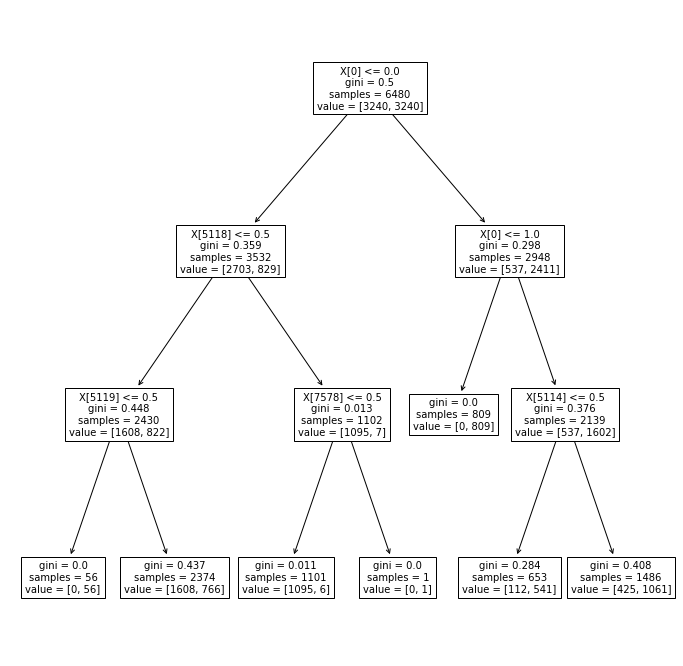

In [32]:
import matplotlib.pyplot as plt
from sklearn import tree
#tree.plot_tree(dataset,feature_names=dataset.drop('stroke',axis=1).columns,max_depth = 2,filled=True,class_names = True)
#tree.plot_tree(dataset)
dataset = tree.DecisionTreeClassifier(max_depth=3)
dataset.fit(X_train_sm, y_train_sm)
plt.figure(figsize=(12,12))
tree.plot_tree(dataset, fontsize=10)
plt.show()

In [33]:
#Test Baseline
# Set model parameters (currently set as default values, but defined here to be explicit)
rf_params = {'n_estimators': 50, 'min_samples_split': 5, 'bootstrap': False}

# Train Model
rf_model = RandomForestClassifier(**rf_params)
#rf_model.fit(X_train, y_train)
rf_model.fit(X_train_sm, y_train_sm.ravel())
y_pred_rf = rf_model.predict(X_test)

# display performance 
print("\n", "Random Forest Prediction Scores:", "\n", 
      classification_report(y_test, y_pred_rf, target_names=['Stroke', 'No Stroke']))


 Random Forest Prediction Scores: 
               precision    recall  f1-score   support

      Stroke       0.97      0.76      0.85      1621
   No Stroke       0.10      0.52      0.17        83

    accuracy                           0.75      1704
   macro avg       0.53      0.64      0.51      1704
weighted avg       0.93      0.75      0.82      1704



In [ ]:
#Model Explainability 
import shap
shap.initjs()

instance_to_explain = X_train_sm
explainer = shap.TreeExplainer(rf_model)

shap_values = explainer.shap_values(instance_to_explain)
dataset_shap = shap_values
dataset = instance_to_explain

shap_v = pd.DataFrame(dataset_shap)
feature_list = dataset.columns
shap_v.columns = feature_list
dataset_v = dataset.copy().reset_index().drop('index',axis=1)

In [ ]:
#Determine the correlation in order to plot with different colors
corr_list = list()
for i in feature_list:
    b = np.corrcoef(shap_v[i],df_v[i])[1][0]
    corr_list.append(b)
corr_dataset = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
# Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
corr_dataset.columns  = ['Variable','Corr']
corr_dataset['Sign'] = np.where(corr_dataset['Corr']>0,'red','blue')

In [ ]:
# Plot it
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']
k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
k2 = k2.sort_values(by='SHAP_abs',ascending = True)

display(k2)

display(shap.summary_plot(shap_values, X_train_sm, plot_type="bar"))

display(shap.summary_plot(shap_values, X_train_sm))

In [ ]:
# Generate comparison table (returned as a pandas dataframe)
meas = fhmc.measure_model(X_test, y_test, X_test['age_coded'], rf_model)
reports.flag(meas)

In [ ]:
# Mitigation Algorithms
from fairlearn.reductions import GridSearch, ExponentiatedGradient

# Fairness Measures
from fairlearn.reductions import EqualizedOdds, DemographicParity 

In [ ]:
# Set seed for consistent results with Fairlearn's ExponentiatedGradient
np.random.seed(36) 

In [ ]:
X_train

In [ ]:
reports.data_report(X_test['age_coded'], y_test)

In [ ]:
reports.performance_report(X_test['age_coded'], y_test, y_pred_rf)

In [ ]:
reports.bias_report(X_test['age_coded'], y_test, y_pred_rf)

In [ ]:
#Fair ExponentiatedGradient Using Demographic Parity as Constraint
eg_rfDP_model = ExponentiatedGradient(XGBClassifier(**rf_params), 
                                      constraints=DemographicParity()) 
eg_rfDP_model.fit(X_train, y_train,
                  sensitive_features=X_train['age_coded'])
#eg_rfDP_model.fit(X_train_res, y_train_res.ravel(),
                  #sensitive_features=X_train_res['age_coded'])
    
y_pred_eg_rfDP = eg_rfDP_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      classification_report(y_test, y_pred_eg_rfDP, 
       target_names=['age <= 65', 'age > 65']))

In [ ]:
#Fair ExponentiatedGradient Using Demographic Parity as Constraint
eg_rfDP_model = ExponentiatedGradient(RandomForestClassifier(**rf_params), 
                                      constraints=DemographicParity()) 
eg_rfDP_model.fit(X_train, y_train,
                  sensitive_features=X_train['age_coded'])
#eg_rfDP_model.fit(X_train_res, y_train_res.ravel(),
                  #sensitive_features=X_train_res['age_coded'])
    
y_pred_eg_rfDP = eg_rfDP_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      classification_report(y_test, y_pred_eg_rfDP, 
       target_names=['age <= 65', 'age > 65']))

In [ ]:
#Fair ExponentiatedGradient Using Equalized Odds as Constraint
eg_rfEO_model = ExponentiatedGradient(RandomForestClassifier(**rf_params), 
                                      constraints=EqualizedOdds())  
eg_rfEO_model.fit(X_train, y_train, 
                  sensitive_features=X_train['age_coded'])
y_pred_eg_rfEO = eg_rfEO_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      classification_report(y_test, y_pred_eg_rfEO, 
       target_names=['age <= 65', 'age > 65']))

In [ ]:
#Fair GridSearch Using Demographic Parity as Constraint
# Train GridSearch
gs_rfDP_model = GridSearch(RandomForestClassifier(**rf_params),
                           constraints=DemographicParity(),
                           grid_size=45)

gs_rfDP_model.fit(X_train, y_train, 
                  sensitive_features=X_train['age_coded'])
y_pred_gs_rfDP = gs_rfDP_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      classification_report(y_test, y_pred_gs_rfDP, 
       target_names=['age <= 65', 'age > 65']))

In [ ]:
#Fair GridSearch Using Equalized Odds as Constraint
# Train GridSearch
gs_rfEO_model = GridSearch(RandomForestClassifier(**rf_params),
                           constraints=EqualizedOdds(),
                           grid_size=45)

gs_rfEO_model.fit(X_train, y_train, 
                  sensitive_features = X_train['age_coded'])
y_pred_gs_rfEO = gs_rfEO_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      classification_report(y_test, y_pred_gs_rfEO, 
       target_names=['age <= 65', 'age > 65']))

In [ ]:
#Comparing Several Models
#Setting the Required Variables
X = X_test
y = y_test
protected_attr = X_test['age_coded']
models = {'rf_model': rf_model,
         'gs_rfEO_model': gs_rfEO_model, 'gs_rfDP_model': gs_rfDP_model,
         'eg_rfEO_model': eg_rfEO_model, 'eg_rfDP_model': eg_rfDP_model}
display("Models being compared in this example:", list(models.keys()))

In [ ]:
#Comparison with the FairMLHealth Tool
# Generate comparison table (returned as a pandas dataframe)
comparison = fhmc.compare_models(X, y, protected_attr, models)

# Here we determine the indices for equal odds measures so that we can highlight according
#    to those indices later
idx = pd.IndexSlice
eotag = idx[:, ['Equal Opportunity Difference', 'Equalized Odds Difference',
                 'Equalized Odds Ratio']
            ]
equal_odds = comparison.loc[eotag, :].index

# Here we return the flagged table as a pandas styler so we can also highlight 
#       measures of Equal Odds
flagged = reports.flag(comparison, as_styler=True)
flagged.apply(lambda x: ['background-color:' + "#DED8F9" 
                          if x.name in equal_odds else '' for i in x]
                , axis=1)